In [2]:
import csv
import random
import os
import pymc as pm
from pymc import do, observe
import pandas as pd
import numpy as np
import arviz as az
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder
from pytensor import tensor as pt
import pickle as pkl
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import itertools as it
import country_converter as cc
import math
from sklearn.linear_model import LinearRegression
import graphviz

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Burke data

In [3]:
data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset.csv")
indices_to_drop = []
no_nan_cols = ["UDel_temp_popweight","UDel_precip_popweight","growthWDI"]
for index, row in enumerate(data.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
data = data.drop(indices_to_drop).reset_index(drop=True)
test_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset_test.csv")
train_data = pd.read_csv("../data/burke/data/input/GrowthClimateDataset_train.csv")
grad_effect_columns = train_data.loc[:, train_data.columns.str.startswith(('_y'))]
ordered_country_list = list(dict.fromkeys(train_data.iso))
enc = OrdinalEncoder()
enc.fit(np.array(ordered_country_list).reshape(-1,1))
data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.iso_id).reshape(-1,1))]

/tmp/ipykernel_3834/3775520672.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.iso_id).reshape(-1,1))]


# Make dataset withholding random data points

In [80]:
random.seed(1)
indices_to_drop = []
all_years = set(data.year)
for year in all_years:
    year_rows = data.loc[data.year == year]
    year_row_indices = list(year_rows.index)
    drop_from_this_year = random.sample(year_row_indices, 6)
    for index in drop_from_this_year:
        indices_to_drop.append(index)
withheld_rows = data.iloc[indices_to_drop]
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index(drop=True)
print(f"Removed {data_len_before - len(data_mod)} rows.")

Removed 300 rows.


In [83]:
data_mod.to_csv("../data/burke/data/input/GrowthClimateDataset_train.csv")

In [84]:
pd.DataFrame(withheld_rows).to_csv("../data/burke/data/input/GrowthClimateDataset_test.csv")

# Delta Method

In [4]:
in_range = 0
out_range = 0
delta_lowers, delta_uppers = [], []
real_y = []

delta_yhat = pd.read_csv("../data/burke/data/input/burke_stdp_pred_outsample.csv")
# delta_yhat = pd.read_csv("../data/burke/data/input/bootstrap/burke_bootstrap_stdp.csv")
for row in enumerate(delta_yhat.itertuples()):
    lower = row[1].lower
    upper = row[1].upper
    real_y.append(row[1].growthwdi)
    if lower <= real_y[-1] and upper >= real_y[-1]:
        in_range += 1
    else:
        out_range += 1
    delta_lowers.append(lower), delta_uppers.append(upper)

print(in_range / len(delta_yhat))
print(out_range / len(delta_yhat))

0.6033333333333334
0.39666666666666667


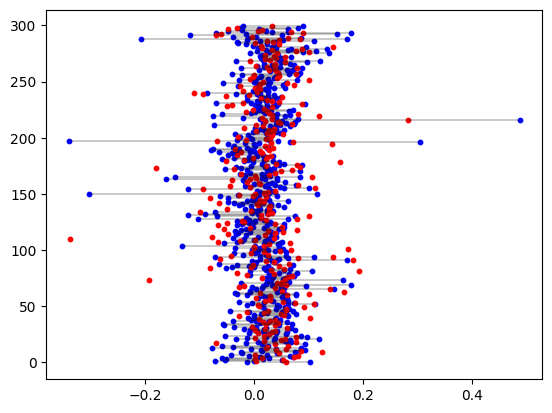

In [145]:
plt.scatter(lowers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(uppers, list(range(len(yhat))), color="blue", s=10)
plt.scatter(real_y, list(range(len(yhat))), color="red", s=10)
for index in range(len(yhat)):
    plt.plot([lowers[index],uppers[index]],[index,index],'k-', linewidth=.3)
plt.show()

# Bayesian model

In [5]:
model = pd.read_pickle('../models/nature_reproduction/burke-reproduction-mcmc-fixed-effects-grad-effects-deterministic-observed-hierarchical-std-error-withheld.pkl')
trace = model["trace"]

In [6]:
bayes_coef1 = trace.posterior.temp_gdp_coef.data.flatten()
bayes_coef2 = trace.posterior.temp_sq_gdp_coef.data.flatten()
bayes_coef3 = trace.posterior.precip_gdp_coef.data.flatten()
bayes_coef4 = trace.posterior.precip_sq_gdp_coef.data.flatten()
intercept = trace.posterior.gdp_intercept.data.flatten()
grad_coefs = np.transpose(np.vstack(trace.posterior.grad_effect_coefs.data))
country_coefs = np.transpose(np.vstack(trace.posterior.country_coefs.data))
year_coefs = np.transpose(np.vstack(trace.posterior.year_coefs.data))

In [7]:
# unscale all model parameters

bayes_coef1 = (bayes_coef1 * np.std(train_data.growthWDI) / np.std(train_data.UDel_temp_popweight)) - (2 * (bayes_coef2 * np.mean(train_data.UDel_temp_popweight * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_temp_popweight))))
bayes_coef2 = (bayes_coef2 * np.std(train_data.growthWDI) / np.square(np.std(train_data.UDel_temp_popweight)))
bayes_coef3 = (bayes_coef3 * np.std(train_data.growthWDI) / np.std(train_data.UDel_precip_popweight)) - (2 * (bayes_coef4 * np.mean(train_data.UDel_precip_popweight * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_precip_popweight))))
bayes_coef4 = (bayes_coef4 * np.std(train_data.growthWDI)) / np.square(np.std(train_data.UDel_precip_popweight))

intercept = (intercept * np.std(train_data.growthWDI)) + np.mean(train_data.growthWDI) - ((bayes_coef1 * np.mean(train_data.UDel_temp_popweight)) + (bayes_coef2 * np.square(np.mean(train_data.UDel_temp_popweight))) + (bayes_coef3 * np.mean(train_data.UDel_precip_popweight)) + (bayes_coef4 * np.square(np.mean(train_data.UDel_precip_popweight))))
for i in range(len(grad_coefs)):
    grad_coefs[i] = (grad_coefs[i] * np.std(train_data.growthWDI))
for i in range(len(country_coefs)):
    country_coefs[i] = country_coefs[i] * np.std(train_data.growthWDI)
for i in range(len(year_coefs)):
    year_coefs[i] = year_coefs[i] * np.std(train_data.growthWDI)

In [8]:
bayes_yhat = []
real_y = []
min_year = min(train_data.year)
grad_effect_column_names = list(grad_effect_columns)
for row in test_data.iterrows():
# for row in train_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    real_y.append(row[1].growthWDI)
    if country == ordered_country_list[0]:
        country_effect = 0
    else:
        country_effect = country_coefs[ordered_country_list.index(country)-1]
    if year - min_year == 0:
        year_effect = 0
    else:
        year_effect = year_coefs[year - min_year -1]
    predict_gdp = (
        temp*bayes_coef1 + 
        np.square(temp)*bayes_coef2 +
        precip*bayes_coef3 +
        np.square(precip)*bayes_coef4 +
        country_effect +
        year_effect +
        intercept
    )
    grad_effect = 0
    for i, effect in enumerate(grad_effect_column_names):
        grad_effect += row[1][effect]* grad_coefs[i]
    predict_gdp += grad_effect
    bayes_yhat.append(sorted(predict_gdp))

In [9]:
in_range, out_range = 0, 0
bayes_lowers, bayes_uppers = [], []
for index, prediction in enumerate(bayes_yhat):
    interval = np.quantile(prediction,[.025,.975])
    bayes_lowers.append(interval[0])
    bayes_uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(bayes_yhat))
print(out_range/len(bayes_yhat))

0.6066666666666667
0.3933333333333333


(0.0028258472135698626, 0.09564053460970416)


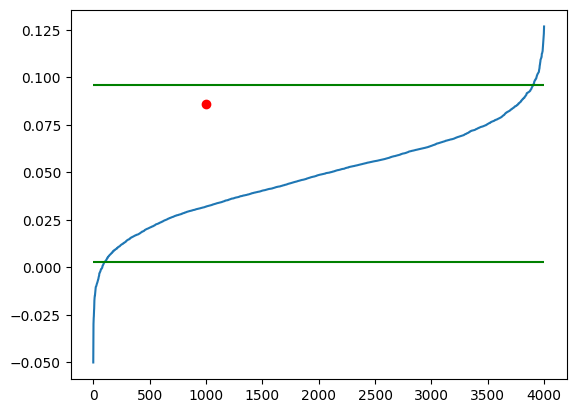

In [233]:
index = 10
plt.plot(yhat[index])
plt.plot(1000,real_y[index],'ro')
interval = (yhat[index][int(len(yhat[index])*.025)],yhat[index][int(len(yhat[index])*.975)])
print(interval)
plt.hlines(interval[0],0,4000,color="green")
plt.hlines(interval[1],0,4000,color="green")

# Bootstrap from Stata

In [10]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications.csv")
column_names = list(bootstrap_reps.iloc[0])
for index, column in enumerate(column_names):
    if "year" in column:
        column_names[index] = column.split("[")[1].split(".")[0].replace("b","")
    elif "isoxtim" in column:
        column_names[index] = column.split("[")[1].split("]")[0].replace("o.","")
    elif "encoded_iso_id" in column:
        column_names[index] = ordered_country_list[int(column.split("[")[1].split(".")[0].replace("b",""))]
bootstrap_reps.iloc[0] = column_names
bootstrap_reps.to_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_better_column_names.csv")

/tmp/ipykernel_3834/3439787215.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,26

In [11]:
bootstrap_reps = pd.read_csv("../data/burke/data/input/bootstrap/burke_stata_bootstrap_replications_better_column_names.csv", header=1)

indices_to_drop = []
no_nan_cols = ["coef1"]
for index, row in enumerate(bootstrap_reps.itertuples()):
    if any(np.isnan(getattr(row,col)) for col in no_nan_cols):
        indices_to_drop.append(index)
bootstrap_reps = bootstrap_reps.drop(indices_to_drop)

boot_yhat = []
real_y = []
min_year = min(train_data.year)
grad_effect_column_names = list(grad_effect_columns)
for row in test_data.iterrows():
# for row in train_data.iterrows():
    temp = row[1].UDel_temp_popweight
    precip = row[1].UDel_precip_popweight
    country = row[1].iso
    year = row[1].year
    real_y.append(row[1].growthWDI)
    predict_gdp = (
        temp*bootstrap_reps.coef1 + 
        np.square(temp)*bootstrap_reps.coef2 +
        precip*bootstrap_reps.coef3 +
        np.square(precip)*bootstrap_reps.coef4 +
        bootstrap_reps[country] +
        bootstrap_reps[str(year)] +
        bootstrap_reps["intercept"]
    )
    grad_effect = 0
    for i, effect in enumerate(grad_effect_column_names):
        grad_effect += row[1][effect]* bootstrap_reps[effect.lower()]
    predict_gdp += grad_effect
    boot_yhat.append(sorted(predict_gdp))

In [13]:
in_range, out_range = 0, 0
boot_lowers, boot_uppers = [], []
for index, prediction in enumerate(boot_yhat):
    interval = np.quantile(prediction,[.025,.975])
    boot_lowers.append(interval[0])
    boot_uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(boot_yhat))
print(out_range/len(boot_yhat))

0.4866666666666667
0.5133333333333333


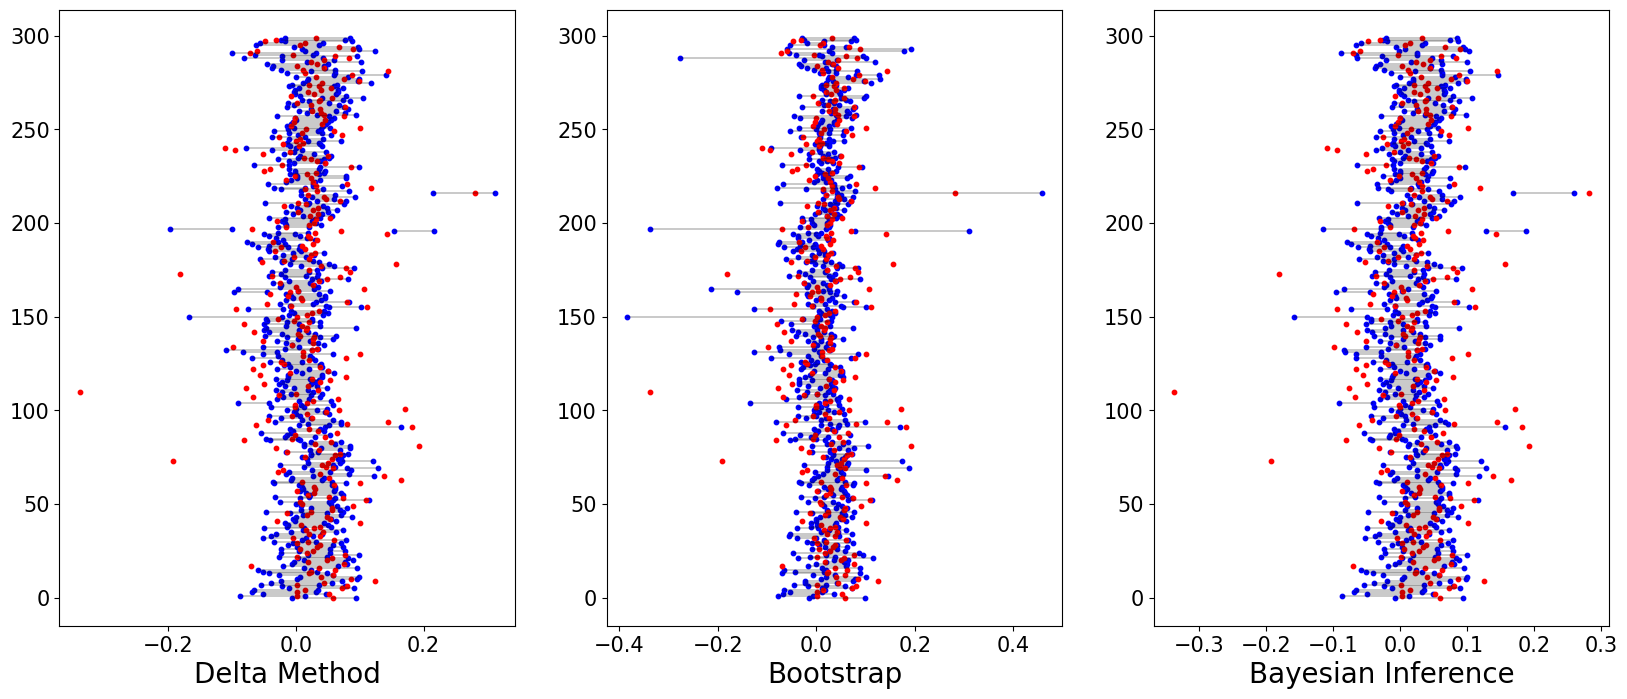

In [19]:
burke_fig, (burke_ax1, burke_ax2, burke_ax3) = plt.subplots(1,3, figsize=(20,8))

burke_ax1.scatter(delta_lowers, list(range(len(delta_yhat))), color="blue", s=10)
burke_ax1.scatter(delta_uppers, list(range(len(delta_yhat))), color="blue", s=10)
burke_ax1.scatter(real_y, list(range(len(delta_yhat))), color="red", s=10)
for index in range(len(delta_yhat)):
    burke_ax1.plot([delta_lowers[index],delta_uppers[index]],[index,index],'k-', linewidth=.3)
burke_ax1.set_xlabel("Delta Method")
burke_ax1.xaxis.label.set_size(20)
burke_ax1.xaxis.set_tick_params(labelsize=15)
burke_ax1.yaxis.set_tick_params(labelsize=15)

burke_ax2.scatter(boot_lowers, list(range(len(boot_yhat))), color="blue", s=10)
burke_ax2.scatter(boot_uppers, list(range(len(boot_yhat))), color="blue", s=10)
burke_ax2.scatter(real_y, list(range(len(boot_yhat))), color="red", s=10)
for index in range(len(boot_yhat)):
    burke_ax2.plot([boot_lowers[index],boot_uppers[index]],[index,index],'k-', linewidth=.3)
burke_ax2.set_xlabel("Bootstrap")
burke_ax2.xaxis.label.set_size(20)
burke_ax2.xaxis.set_tick_params(labelsize=15)
burke_ax2.yaxis.set_tick_params(labelsize=15)

burke_ax3.scatter(bayes_lowers, list(range(len(bayes_yhat))), color="blue", s=10)
burke_ax3.scatter(bayes_uppers, list(range(len(bayes_yhat))), color="blue", s=10)
burke_ax3.scatter(real_y, list(range(len(bayes_yhat))), color="red", s=10)
for index in range(len(bayes_yhat)):
    burke_ax3.plot([bayes_lowers[index],bayes_uppers[index]],[index,index],'k-', linewidth=.3)
burke_ax3.set_xlabel("Bayesian Inference")
burke_ax3.xaxis.label.set_size(20)
burke_ax3.xaxis.set_tick_params(labelsize=15)
burke_ax3.yaxis.set_tick_params(labelsize=15)

burke_fig.savefig("../figures/burke_prediction_intervals.png", bbox_inches='tight')

# Ortiz-Bobea data

In [20]:
data = pd.read_csv("../data/ortiz-bobea/data2/regdata_preferred_case.csv")
test_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_test.csv")
train_data = pd.read_csv("../data/ortiz-bobea/data2/regdata_train.csv")
ordered_country_list = list(dict.fromkeys(train_data.ISO3))
enc = OrdinalEncoder()
enc.fit(np.array(ordered_country_list).reshape(-1,1))
data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.ISO3).reshape(-1,1))]

/tmp/ipykernel_3834/3786652120.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  data["encoded_iso_id"] = [int(val) for val in enc.transform(np.array(data.ISO3).reshape(-1,1))]


# Make dataset withholding random points

In [108]:
indices_to_drop = []
all_years = set(data.year)
for year in all_years:
    year_rows = data.loc[data.year == year]
    year_row_indices = list(year_rows.index)
    drop_from_this_year = random.sample(year_row_indices, 6)
    for index in drop_from_this_year:
        indices_to_drop.append(index)
withheld_rows = data.iloc[indices_to_drop]
data_len_before = len(data)
data_mod = data.drop(indices_to_drop)
data_mod = data_mod.reset_index(drop=True)
print(f"Removed {data_len_before - len(data_mod)} rows.")

Removed 300 rows.


In [11]:
data_mod.to_csv("../data/ortiz-bobea/data2/regdata_train.csv")

In [12]:
pd.DataFrame(withheld_rows).to_csv("../data/ortiz-bobea/data2/regdata_test.csv")

In [ ]:
pd.DataFrame(data).to_csv("../data/ortiz-bobea/data2/regdata_preferred_case_encoded_iso_id.csv")

# Delta method

In [21]:
in_range = 0
out_range = 0
delta_lowers, delta_uppers = [], []
real_y = []

delta_yhat = pd.read_csv("../data/ortiz-bobea/data2/ortiz_stdp_pred_outsample.csv")
# yhat = pd.read_csv("../data/ortiz-bobea/data2/ortiz_stdp_pred_insample.csv")
for row in enumerate(delta_yhat.itertuples()):
    lower = row[1].lower
    upper = row[1].upper
    real_y.append(row[1].fd_log_tfp)
    if lower <= real_y[-1] and upper >= real_y[-1]:
        in_range += 1
    else:
        out_range += 1
    delta_lowers.append(lower), delta_uppers.append(upper)

print(in_range / len(delta_yhat))
print(out_range / len(delta_yhat))

0.38271604938271603
0.6172839506172839


# Bootstrap model from Stata

In [88]:
bootstrap_reps = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_withheld.csv")
column_names = list(bootstrap_reps.iloc[0])
for index, column in enumerate(column_names):
    if "year" in column:
        column_names[index] = column.split("[")[1].split(".")[0].replace("b","")
    elif "isoxtim" in column:
        column_names[index] = column.split("[")[1].split("]")[0].replace("o.","")
    elif "encoded_iso_id" in column:
        column_names[index] = ordered_country_list[int(column.split("[")[1].split(".")[0].replace("b",""))]
    elif "_b" in column:
        if "cons" in column:
            column_names[index] = "intercept"
        else:
            column_names[index] = column.replace("_b[","").replace("]","")
bootstrap_reps.iloc[0] = column_names
bootstrap_reps.to_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_withheld_better_column_names.csv")

In [22]:
bootstrap_reps = pd.read_csv("../data/ortiz-bobea/data2/bootstrap/ortiz_stata_bootstrap_withheld_better_column_names.csv", header=1)

boot_yhat = []
real_y = []
for row in test_data.iterrows():
# for row in train_data.iterrows():
    temp = row[1].fd_tmean
    temp2 = row[1].fd_tmean_sq
    precip = row[1].fd_prcp
    precip2 = row[1].fd_prcp_sq
    country = row[1].ISO3
    year = row[1].year
    real_y.append(row[1].fd_log_tfp)
    predict_tfp = (
        temp*bootstrap_reps["fd_tmean"] + 
        temp2*bootstrap_reps["fd_tmean_sq"] +
        precip*bootstrap_reps["fd_prcp"] +
        precip2*bootstrap_reps["fd_prcp_sq"] +
        bootstrap_reps[country] +
        bootstrap_reps[str(year)] +
        bootstrap_reps["intercept"]
    )
    boot_yhat.append(sorted(predict_tfp))

In [23]:
in_range, out_range = 0, 0
boot_lowers, boot_uppers = [], []
for index, prediction in enumerate(boot_yhat):
    interval = np.quantile(prediction,[.025,.975])
    boot_lowers.append(interval[0])
    boot_uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(boot_yhat))
print(out_range/len(boot_yhat))

0.2962962962962963
0.7037037037037037


# Bayesian model

In [24]:
model = pd.read_pickle('../models/nature_reproduction/ortiz-bobea-reproduction-year-country-fixed-effects-deterministic-observed-hierarchical-std-error-withheld.pkl')
trace = model["trace"]

In [25]:
bayes_coef1 = trace.posterior.fd_temp_tfp_coef.data.flatten()
bayes_coef2 = trace.posterior.fd_sq_temp_tfp_coef.data.flatten()
bayes_coef3 = trace.posterior.fd_precip_tfp_coef.data.flatten()
bayes_coef4 = trace.posterior.fd_sq_precip_tfp_coef.data.flatten()
intercept = trace.posterior.tfp_intercept.data.flatten()
country_coefs = np.transpose(np.vstack(trace.posterior.country_coefs.data))
year_coefs = np.transpose(np.vstack(trace.posterior.year_coefs.data))

In [26]:
bayes_yhat = []
real_y = []
min_year = min(train_data.year)
for row in test_data.iterrows():
# for row in train_data.iterrows():
    temp = row[1].fd_tmean
    temp2 = row[1].fd_tmean_sq
    precip = row[1].fd_prcp
    precip2 = row[1].fd_prcp_sq
    country = row[1].ISO3
    year = row[1].year
    real_y.append(row[1].fd_log_tfp)
    if country == ordered_country_list[0]:
        country_effect = 0
    else:
        country_effect = country_coefs[ordered_country_list.index(country)-1]
    if year - min_year == 0:
        year_effect = 0
    else:
        year_effect = year_coefs[year - min_year -1]
    predict_tfp = (
        temp*bayes_coef1 + 
        temp2*bayes_coef2 +
        precip*bayes_coef3 +
        precip2*bayes_coef4 +
        country_effect +
        year_effect +
        intercept
    )
    bayes_yhat.append(sorted(predict_tfp))

In [27]:
in_range, out_range = 0, 0
bayes_lowers, bayes_uppers = [], []
for index, prediction in enumerate(bayes_yhat):
    interval = np.quantile(prediction,[.025,.975])
    bayes_lowers.append(interval[0])
    bayes_uppers.append(interval[1])
    if real_y[index] >= interval[0] and real_y[index] <= interval[1]:
        in_range += 1
    else:
        out_range += 1
print(in_range/len(bayes_yhat))
print(out_range/len(bayes_yhat))

0.38580246913580246
0.6141975308641975


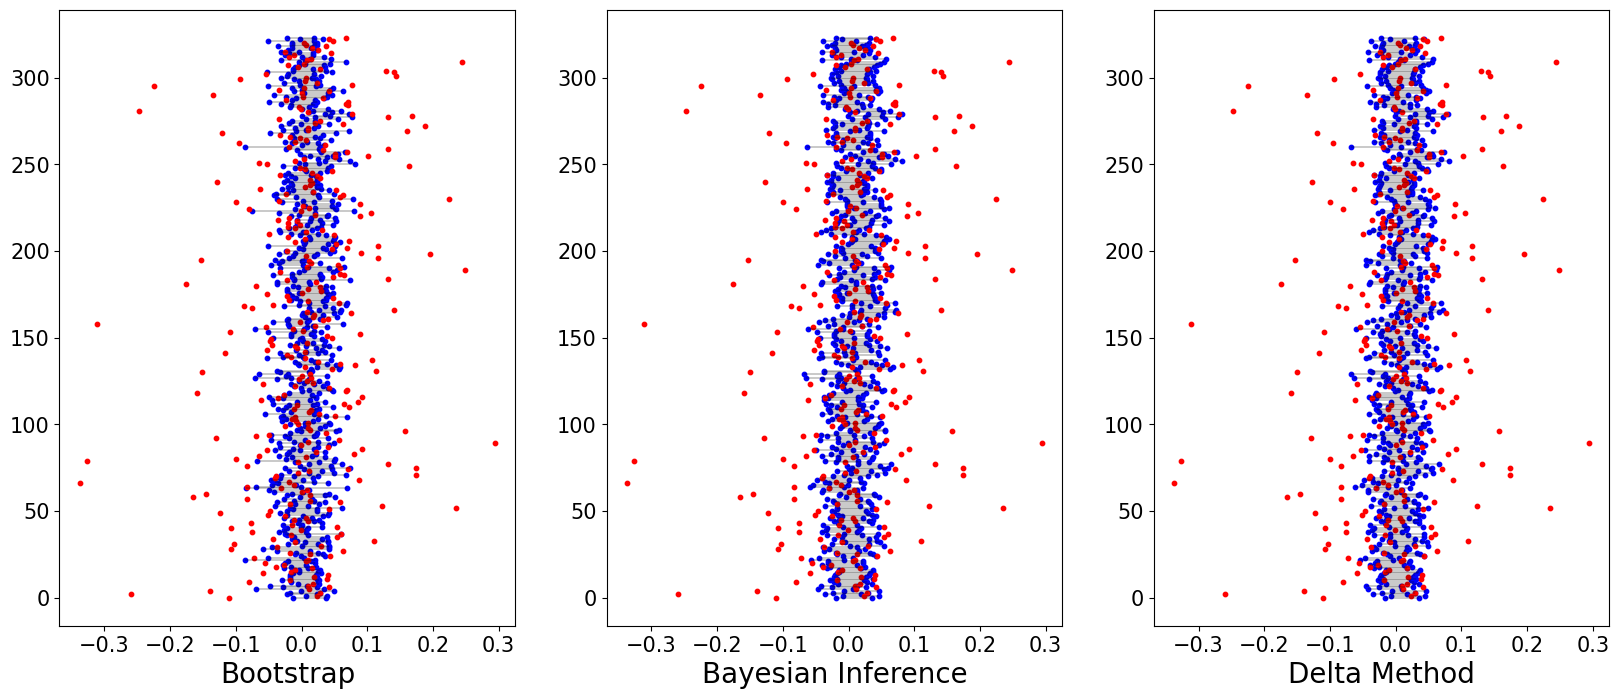

In [28]:
ortiz_fig, (ortiz_ax1, ortiz_ax2, ortiz_ax3) = plt.subplots(1,3, figsize=(20,8))

ortiz_ax1.scatter(boot_lowers, list(range(len(boot_yhat))), color="blue", s=10)
ortiz_ax1.scatter(boot_uppers, list(range(len(boot_yhat))), color="blue", s=10)
ortiz_ax1.scatter(real_y, list(range(len(boot_yhat))), color="red", s=10)
for index in range(len(boot_yhat)):
    ortiz_ax1.plot([boot_lowers[index],boot_uppers[index]],[index,index],'k-', linewidth=.3)
ortiz_ax1.set_xlabel("Bootstrap")
ortiz_ax1.xaxis.label.set_size(20)
ortiz_ax1.xaxis.set_tick_params(labelsize=15)
ortiz_ax1.yaxis.set_tick_params(labelsize=15)

ortiz_ax2.scatter(bayes_lowers, list(range(len(bayes_yhat))), color="blue", s=10)
ortiz_ax2.scatter(bayes_uppers, list(range(len(bayes_yhat))), color="blue", s=10)
ortiz_ax2.scatter(real_y, list(range(len(bayes_yhat))), color="red", s=10)
for index in range(len(bayes_yhat)):
    ortiz_ax2.plot([bayes_lowers[index],bayes_uppers[index]],[index,index],'k-', linewidth=.3)
ortiz_ax2.set_xlabel("Bayesian Inference")
ortiz_ax2.xaxis.label.set_size(20)
ortiz_ax2.xaxis.set_tick_params(labelsize=15)
ortiz_ax2.yaxis.set_tick_params(labelsize=15)

ortiz_ax3.scatter(delta_lowers, list(range(len(delta_yhat))), color="blue", s=10)
ortiz_ax3.scatter(delta_uppers, list(range(len(delta_yhat))), color="blue", s=10)
ortiz_ax3.scatter(real_y, list(range(len(delta_yhat))), color="red", s=10)
for index in range(len(delta_yhat)):
    ortiz_ax3.plot([delta_lowers[index],delta_uppers[index]],[index,index],'k-', linewidth=.3)
ortiz_ax3.set_xlabel("Delta Method")
ortiz_ax3.xaxis.label.set_size(20)
ortiz_ax3.xaxis.set_tick_params(labelsize=15)
ortiz_ax3.yaxis.set_tick_params(labelsize=15)
    
ortiz_fig.savefig("../figures/ortiz_prediction_intervals.png", bbox_inches='tight')